# Post Processing Algorithm for L-2130i $\delta^{2}H$ and $\delta^{18}O$ Analysis
Author: Paul Seibert
Last Updated: 2023-05-10

The following is a post processing algorithm based on a combination of post-processing techniques. <br>
The algorithm is summarized as follows:

Correction step|Recommended by|Basis
:---:|:---:|:---:
Memory (deprecated)|Picarro|Remove first 6 injections
Memory|[Geldern and Barth](https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lom.2012.10.1024)|Combined standard deviation/linear solver
Drift|[Geldern and Barth](https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lom.2012.10.1024)|DEST linear regression
Normalization|Dawson|All standards linear regression

<br>

Nomenclature in the algorithm follows [Geldern and Barth](https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lom.2012.10.1024)'s as follows: 
   * DEST = intermediate value standard
   * ANTA = low value standard
   * HIS = high value standard

### Import relevant packages (<font color=red>do not change</font>)

In [33]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import numpy as np

### Plotting Parameters (<font color=blue>change only if necessary</font>) 

In [34]:
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'figure.figsize': (15,10)})
mpl.rcParams['lines.markersize'] = 14
mpl.rcParams['lines.linewidth'] = 0.75

### Get sample data (<font color = green>change path to input raw data </font>)

In [35]:
data_folder = './Picarro_raw_data/'

## Change this one ##
file_name  = 'HIDS2533_IsoWater_20240222_134543'

plots_on = True
#####################

# Remove crazy Picarro variable spaces
data = pd.read_csv(data_folder + file_name + '.csv')
colnames = data.columns.values.tolist() # get column names
colnames = [name.replace(" ","") for name in colnames] # remove crazy spaces
data.columns = colnames

In [36]:
data.head()

,Line,Analysis,TimeCode,Port,InjNr,d(18_16)Mean,d(D_H)Mean,H2O_Mean,Ignore,Good,...,h16od_adjust,h16od_shift,n2_flag,Resistance,DASTemp,Tray,Sample,Job,Method,ErrorCode
0,1,P-344,2024/02/22 13:51:08,1-01,1,-17.725,-141.137,20762,-1,1,...,0.0,0.0,0,21.70,39.125,1,1,1,2.0ul Picarro Standard,0
1,2,P-344,2024/02/22 14:00:08,1-01,2,-18.108,-144.475,19883,-1,1,...,-0.0,-0.0,0,21.66,39.000,1,1,1,2.0ul Picarro Standard,0
2,3,P-344,2024/02/22 14:09:07,1-01,3,-18.110,-144.430,19728,-1,1,...,0.0,0.0,0,21.64,38.938,1,1,1,2.0ul Picarro Standard,0
3,4,P-344,2024/02/22 14:18:04,1-01,4,-18.115,-144.611,19683,0,1,...,-0.0,-0.0,0,21.58,39.125,1,1,1,2.0ul Picarro Standard,0
4,5,P-344,2024/02/22 14:27:02,1-01,5,-18.130,-144.696,19747,0,1,...,0.0,0.0,0,21.60,39.062,1,1,1,2.0ul Picarro Standard,0


### Get standard file (<font color = blue>change path to standard file</font>)

In [37]:
standards_folder = './standards_files/'

## Change this one ##
std_file_name  = 'USGS_standards_values'
#####################

standards = pd.read_csv(standards_folder + std_file_name + '.csv')

### Plot Uncorrected Data (<font color=red>do not change</font>)

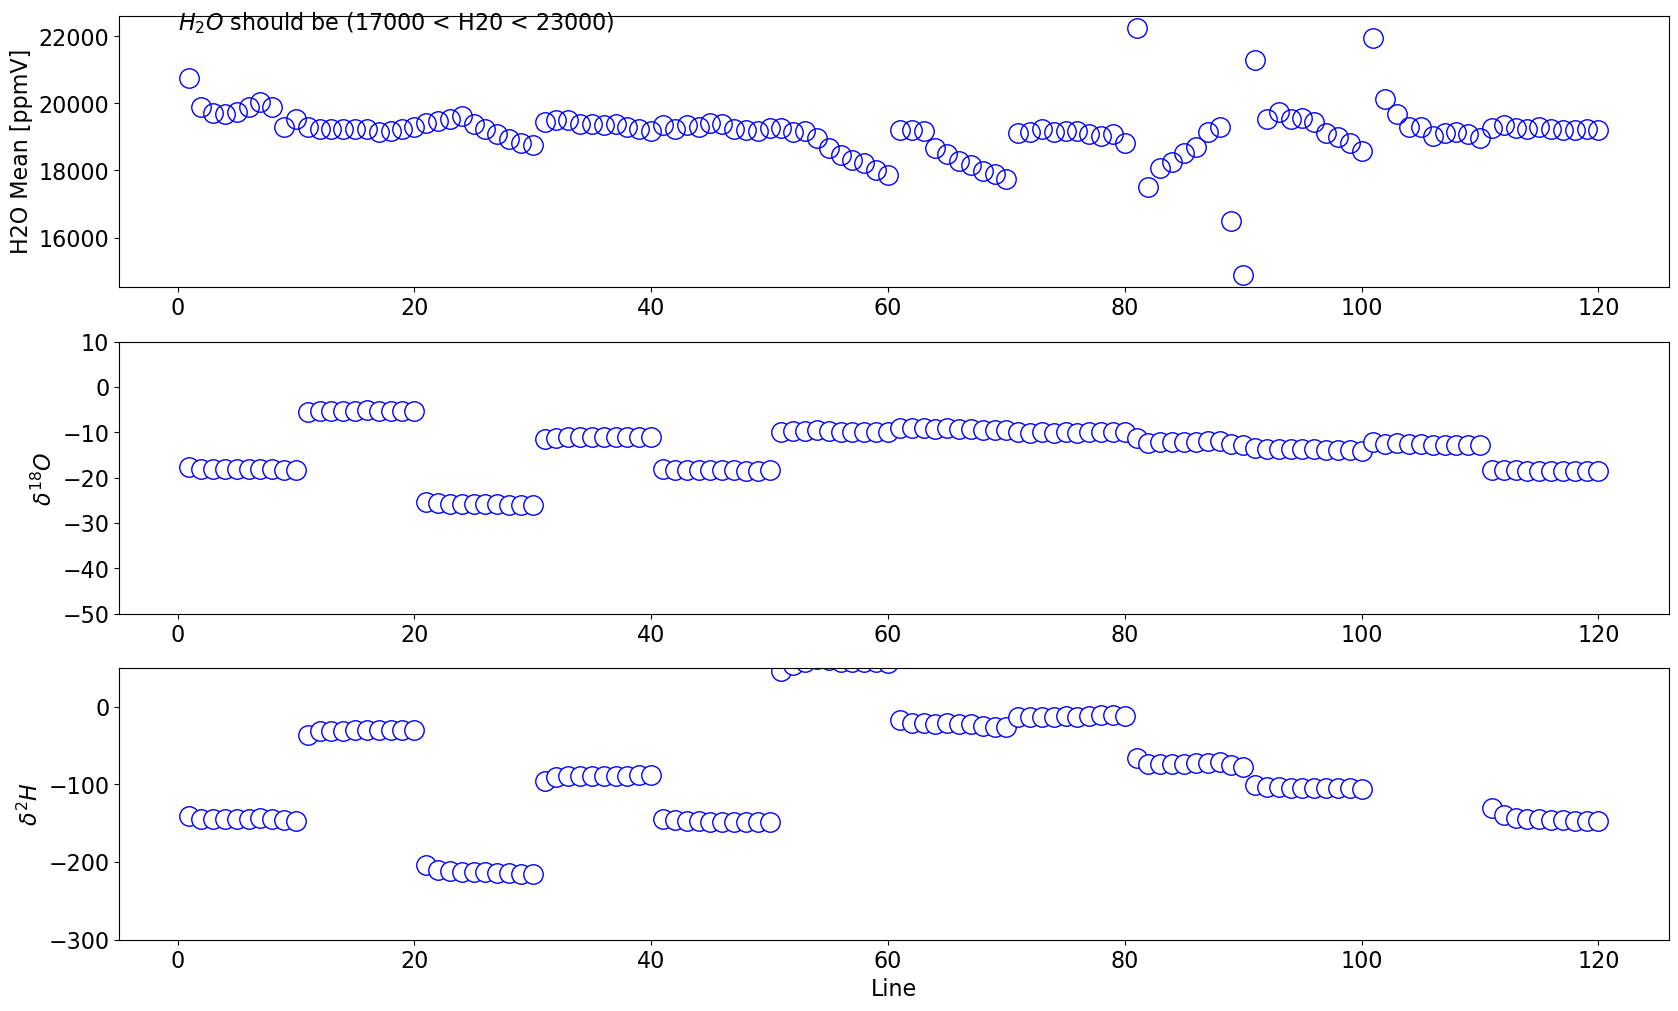

In [38]:
if plots_on == True:
    x = data['Line']
    fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize = (20,12))
    ax1.plot(x,data['H2O_Mean'],'bo',mfc='none')
    ax1.set_ylabel('H2O Mean [ppmV]')
    ax1.annotate('$H_{2}O$ should be (17000 < H20 < 23000)',
                 xy =(0,max(data['H2O_Mean'])-50))
    # ax1.set_ylim(15000,23000)

    ax2.plot(x,data['d(18_16)Mean'],'bo',mfc='white')
    ax2.set_ylabel(u'$\delta^{18}O  $ ')
    ax2.set_ylim(-50,10)

    ax3.plot(x,data['d(D_H)Mean'],'bo',mfc='white')
    ax3.set_ylabel(u'$\delta^{2}H  $ ')
    ax3.set_xlabel('Line')
    ax3.set_ylim(-300,50)

In [39]:
max(data['H2O_Mean'])

22245

### Memory correction (<font color=red>do not change</font>)
Picarro recommended method. Removes the first three injections of each sample. 

In [40]:
data = data[data['Ignore'] != -1] 

### Drift Correction (<font color=red>do not change</font>)

In [41]:
# Subset to only include DEST for drift correction
mask = (data['Identifier1'].str.contains('DEST|USGS_47'))
drift = data[mask]

In [42]:
# Define drift correction function
def drift_correct(x,y,slope):
   return x - slope*y

#### Hydrogen 

In [43]:
drift

,Line,Analysis,TimeCode,Port,InjNr,d(18_16)Mean,d(D_H)Mean,H2O_Mean,Ignore,Good,...,h16od_adjust,h16od_shift,n2_flag,Resistance,DASTemp,Tray,Sample,Job,Method,ErrorCode
3,4,P-344,2024/02/22 14:18:04,1-01,4,-18.115,-144.611,19683,0,1,...,-0.0,-0.0,0,21.58,39.125,1,1,1,2.0ul Picarro Standard,0
4,5,P-344,2024/02/22 14:27:02,1-01,5,-18.130,-144.696,19747,0,1,...,0.0,0.0,0,21.60,39.062,1,1,1,2.0ul Picarro Standard,0
5,6,P-344,2024/02/22 14:36:00,1-01,6,-18.091,-144.233,19907,0,1,...,0.0,0.0,0,21.65,39.000,1,1,1,2.0ul Picarro Standard,0
6,7,P-344,2024/02/22 14:44:58,1-01,7,-18.047,-143.742,20045,0,1,...,-0.0,-0.0,0,21.61,39.000,1,1,1,2.0ul Picarro Standard,0
7,8,P-344,2024/02/22 14:53:55,1-01,8,-18.090,-145.053,19899,0,1,...,-0.0,-0.0,0,21.65,38.938,1,1,1,2.0ul Picarro Standard,0
8,9,P-344,2024/02/22 15:02:53,1-01,9,-18.297,-146.438,19306,0,1,...,0.0,0.0,0,21.68,38.875,1,1,1,2.0ul Picarro Standard,0
9,10,P-344,2024/02/22 15:11:51,1-01,10,-18.290,-146.570,19531,0,1,...,0.0,0.0,0,21.61,38.938,1,1,1,2.0ul Picarro Standard,0
43,44,P-348,2024/02/22 20:16:45,1-01,4,-18.356,-147.729,19308,0,1,...,-0.0,-0.0,0,21.70,39.500,1,1,2,2.0ul Picarro Standard,0
44,45,P-348,2024/02/22 20:25:45,1-01,5,-18.403,-147.890,19402,0,1,...,-0.0,-0.0,0,21.58,39.375,1,1,2,2.0ul Picarro Standard,0
45,46,P-348,2024/02/22 20:34:42,1-01,6,-18.368,-147.795,19382,0,1,...,-0.0,-0.0,0,21.68,39.250,1,1,2,2.0ul Picarro Standard,0


C:\Users\pauls\AppData\Local\Temp\ipykernel_24872\1313479205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drift.loc[:,'d(D_H)_driftcorrected'] = drift.apply(lambda x: drift_correct(x['d(D_H)Mean'], x['Line'],slope), axis=1)


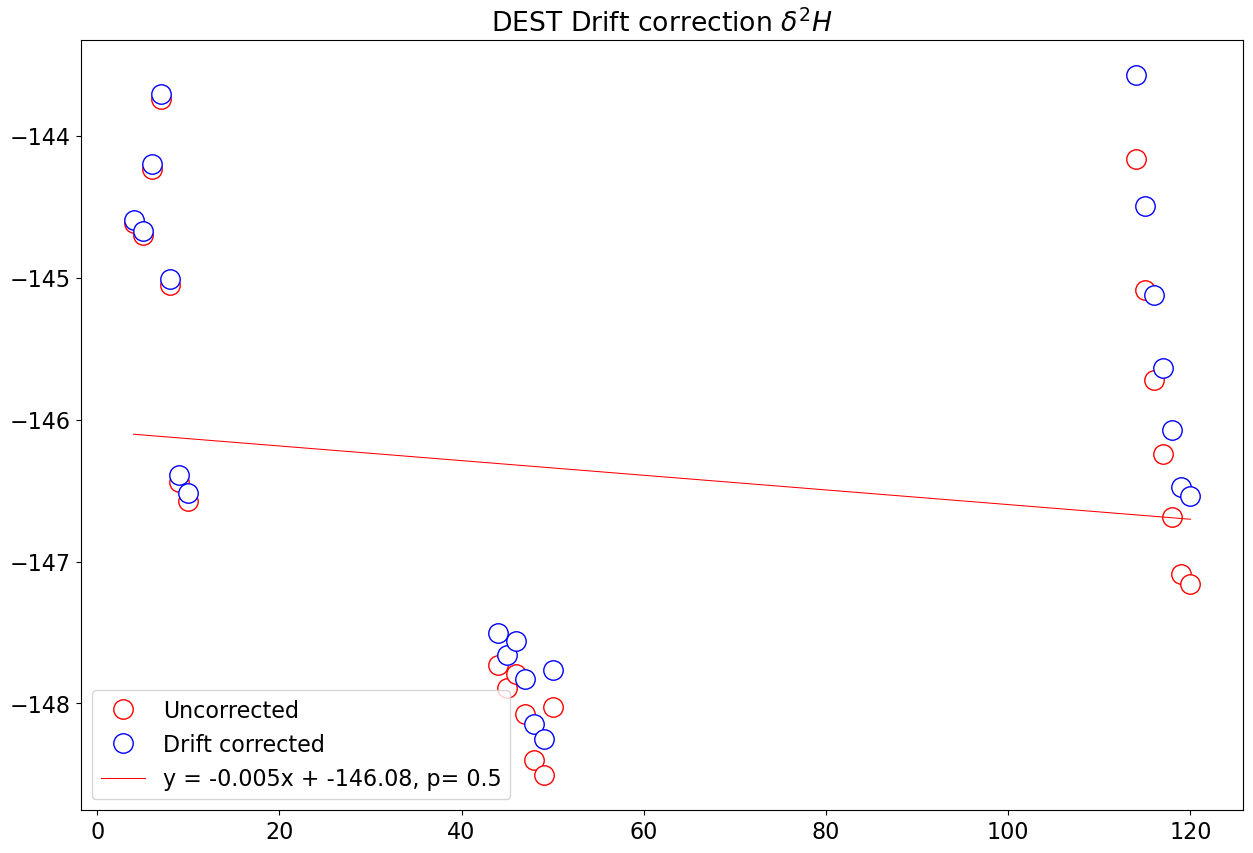

In [44]:
slope, intercept, r_value, p_value, std_err = stats.linregress(drift['Line'], drift['d(D_H)Mean'])

drift.loc[:,'d(D_H)_driftcorrected'] = drift.apply(lambda x: drift_correct(x['d(D_H)Mean'], x['Line'],slope), axis=1)

if plots_on == True:
    fig, ax = plt.subplots()
    x = drift['Line']
    y = slope*x + intercept
    ax.plot(x,drift['d(D_H)Mean'],'ro',mfc='white',label='Uncorrected')
    ax.plot(x,drift['d(D_H)_driftcorrected'],'bo',mfc='white',label='Drift corrected')
    ax.plot(x,y,'r-',
            label="y = " + str(round(slope,3)) + "x + " + str(round(intercept,2)) + ", p= " + str(round(p_value,3)))
    ax.legend()
    plt.title('DEST Drift correction $\delta^{2}H$')

##### Apply to full data

In [45]:
data.loc[:,'d(D_H)_driftcorrected'] = data.apply(lambda x: drift_correct(x['d(D_H)Mean'], x['Line'],slope), axis=1)

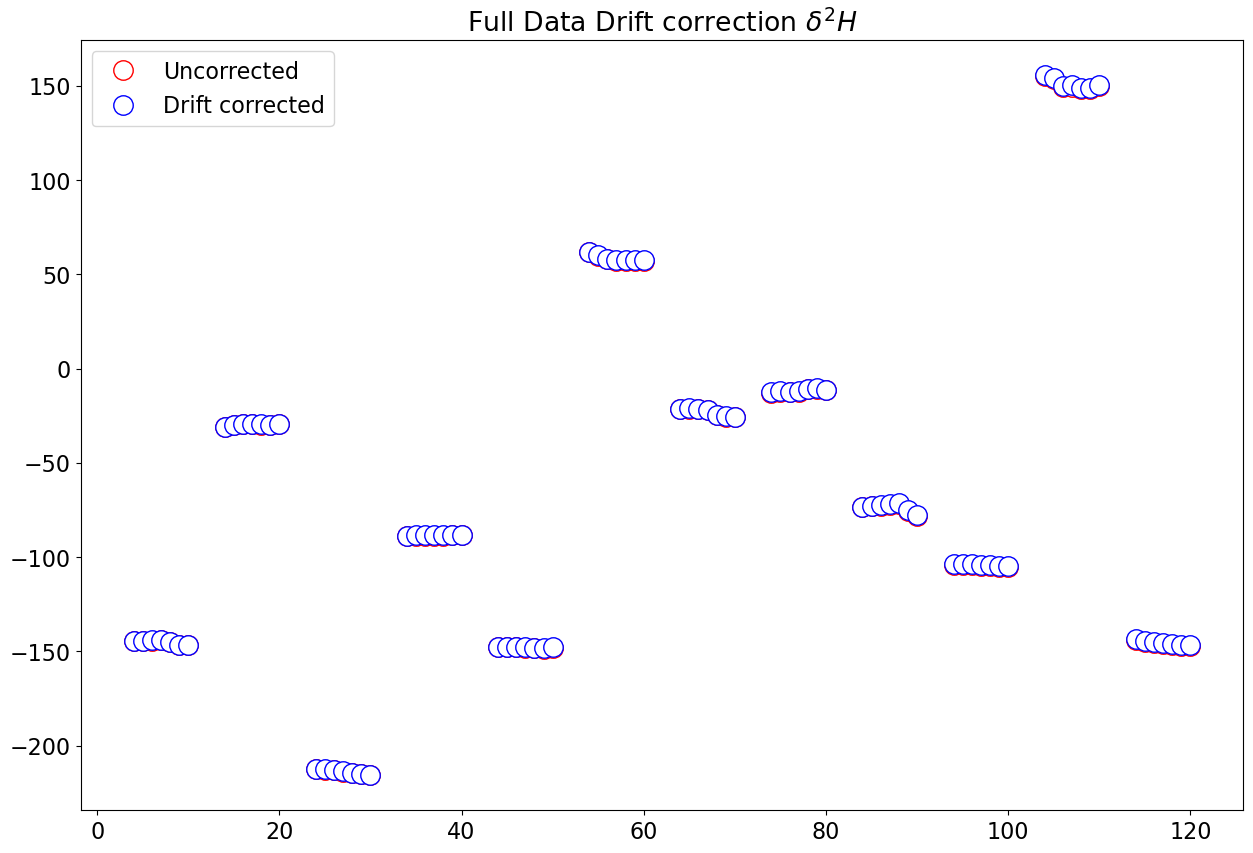

In [46]:
if plots_on == True:
    fig, ax = plt.subplots()
    ax.plot(data['Line'],data['d(D_H)Mean'],'ro',mfc='white',label='Uncorrected')
    ax.plot(data['Line'],data['d(D_H)_driftcorrected'],'bo',mfc='white',label='Drift corrected')
    ax.legend()
    plt.title('Full Data Drift correction $\delta^{2}H$')

#### Oxygen

C:\Users\pauls\AppData\Local\Temp\ipykernel_24872\4018834517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drift['d(18_16)_driftcorrected'] = drift.apply(lambda x: drift_correct(x['d(18_16)Mean'], x['Line'],slope), axis=1)


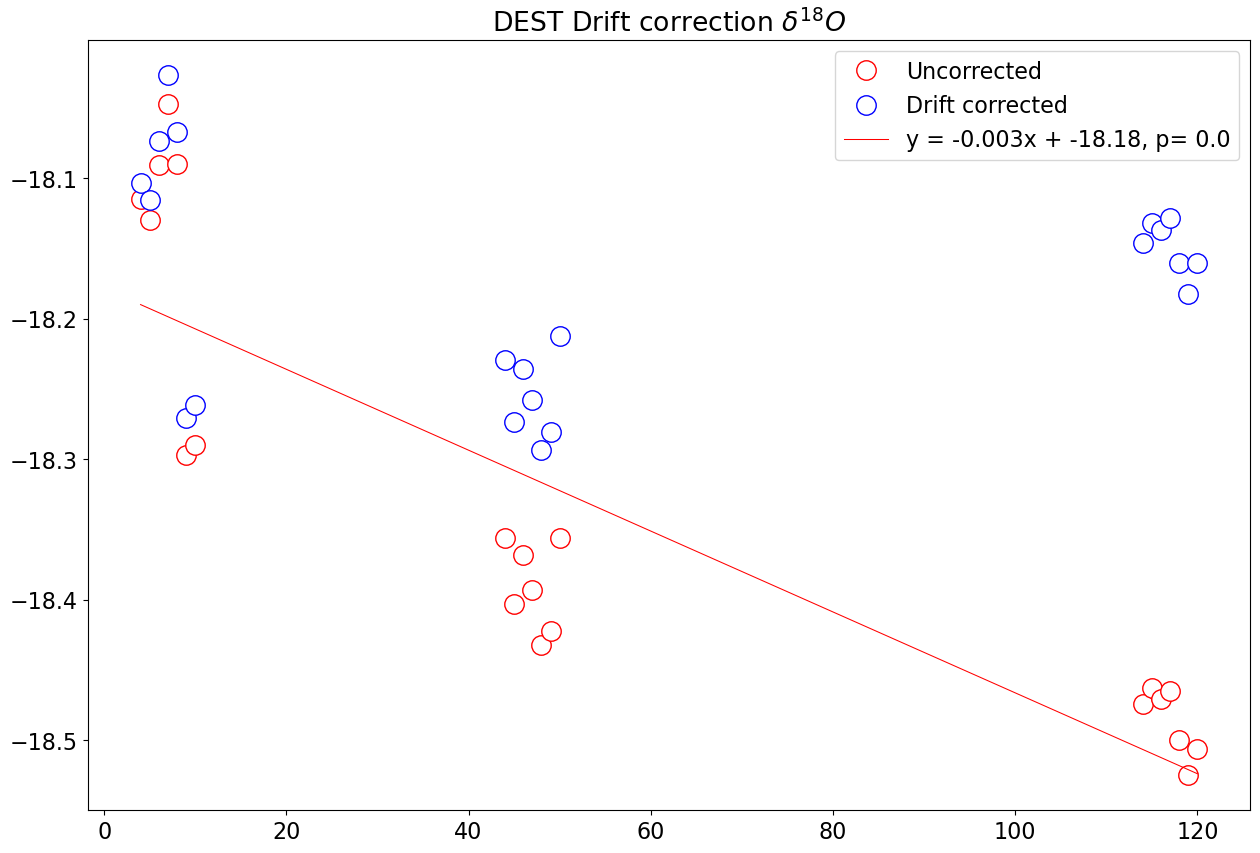

In [47]:
slope, intercept, r_value, p_value, std_err = stats.linregress(drift['Line'], drift['d(18_16)Mean'])

drift['d(18_16)_driftcorrected'] = drift.apply(lambda x: drift_correct(x['d(18_16)Mean'], x['Line'],slope), axis=1)

if plots_on == True:
    fig, ax = plt.subplots()
    x = drift['Line']
    y = slope*x + intercept
    ax.plot(x,drift['d(18_16)Mean'],'ro',mfc='white',label='Uncorrected')
    ax.plot(x,drift['d(18_16)_driftcorrected'],'bo',mfc='white',label='Drift corrected')
    ax.plot(x,y,'r-',
            label="y = " + str(round(slope,3)) + "x + " + str(round(intercept,2)) + ", p= " + str(round(p_value,3)))
    plt.title('DEST Drift correction $\delta^{18}O$')
    ax.legend()

##### Apply to full data

In [48]:
data.loc[:,'d(18_16)_driftcorrected'] = data.apply(lambda x: drift_correct(x['d(18_16)Mean'], x['Line'],slope), axis=1)

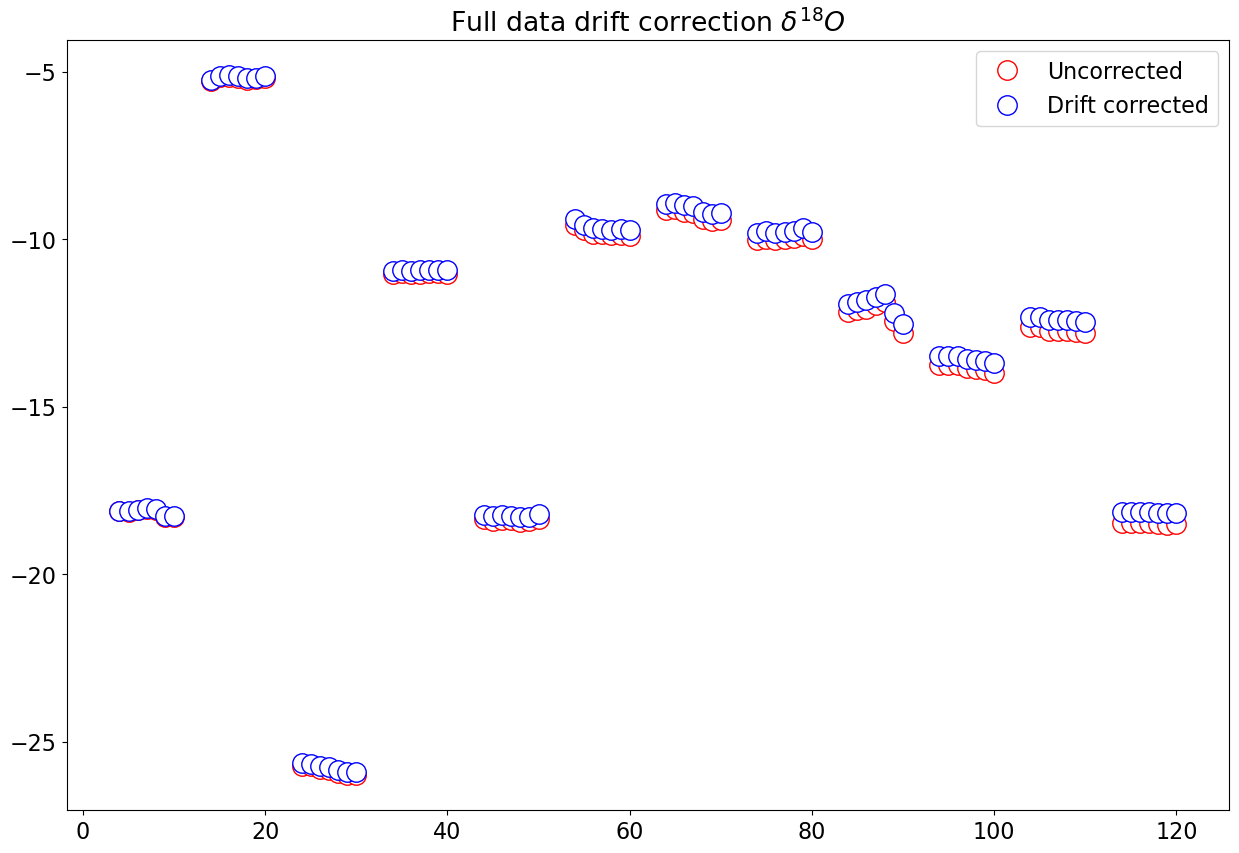

In [49]:
if plots_on == True:
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(data['Line'],data['d(18_16)Mean'],'ro',mfc='white',label='Uncorrected')
    ax.plot(data['Line'],data['d(18_16)_driftcorrected'],'bo',mfc='white',label='Drift corrected')
    ax.legend()
    plt.title('Full data drift correction $\delta^{18}O$')

### Normalization (<font color=red>do not change</font>)

In [50]:
mask = (data['Identifier1'].str.contains('standard|USGS'))
norm = data[mask]

In [51]:
standards['Purpose'] = standards['Purpose'].astype(str)

In [52]:
norm.loc[norm['Identifier1'].str.contains('DEST|USGS_47'), 'd(18_16)_true'] = standards[standards['Purpose']=='DEST']['d18O_mean'][1]
norm.loc[norm['Identifier1'].str.contains('ANTA|USGS_46'), 'd(18_16)_true'] = standards[standards['Purpose']=='ANTA']['d18O_mean'][0]
norm.loc[norm['Identifier1'].str.contains('HIS|USGS_48'), 'd(18_16)_true'] = standards[standards['Purpose']=='HIS']['d18O_mean'][2]

norm.loc[norm['Identifier1'].str.contains('DEST|USGS_47'), 'd(D_H)_true'] = standards[standards['Purpose']=='DEST']['dD_mean'][1]
norm.loc[norm['Identifier1'].str.contains('ANTA|USGS_46'), 'd(D_H)_true'] = standards[standards['Purpose']=='ANTA']['dD_mean'][0]
norm.loc[norm['Identifier1'].str.contains('HIS|USGS_48'), 'd(D_H)_true'] = standards[standards['Purpose']=='HIS']['dD_mean'][2]

C:\Users\pauls\AppData\Local\Temp\ipykernel_24872\3987445945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm.loc[norm['Identifier1'].str.contains('DEST|USGS_47'), 'd(18_16)_true'] = standards[standards['Purpose']=='DEST']['d18O_mean'][1]
C:\Users\pauls\AppData\Local\Temp\ipykernel_24872\3987445945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm.loc[norm['Identifier1'].str.contains('DEST|USGS_47'), 'd(D_H)_true'] = standards[standards['Purpose']=='DEST']['dD_mean'][1]


In [53]:
# Define normalizing function
def normalize(x,slope, intercept):
   return slope*x + intercept

#### Oxygen

C:\Users\pauls\AppData\Local\Temp\ipykernel_24872\3859387029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm['d(18_16)_normalized'] = norm.apply(lambda x: normalize(x['d(18_16)_driftcorrected'],slope,intercept), axis=1)


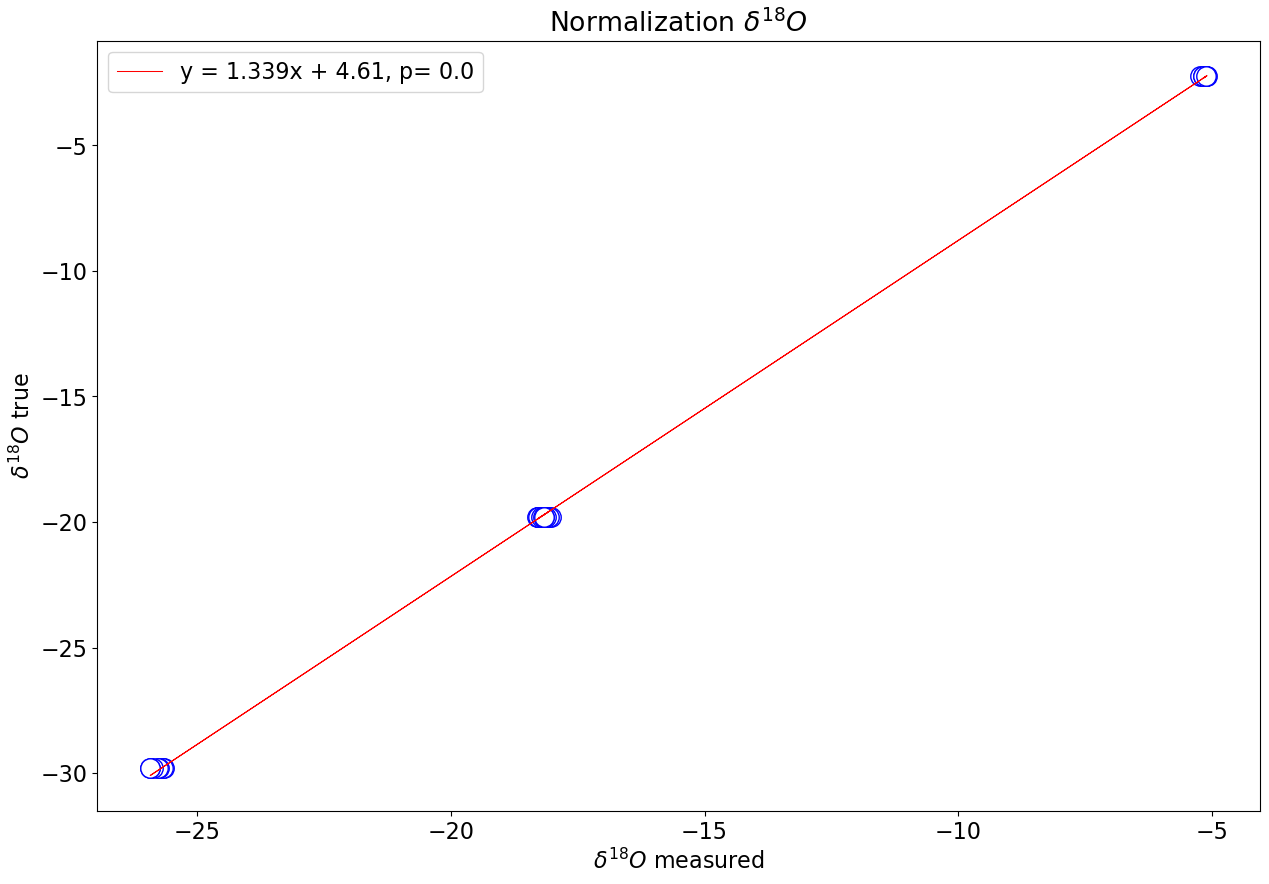

In [54]:
slope, intercept, r_value, p_value, std_err = stats.linregress(norm['d(18_16)_driftcorrected'], norm['d(18_16)_true'])


norm['d(18_16)_normalized'] = norm.apply(lambda x: normalize(x['d(18_16)_driftcorrected'],slope,intercept), axis=1)

if plots_on == True:
    fig, ax = plt.subplots()
    x = norm['d(18_16)_driftcorrected']
    y = slope*x + intercept
    ax.plot(norm['d(18_16)_driftcorrected'],
            norm['d(18_16)_true'],
            'bo',mfc='white')
    ax.plot(x,y,'r-',
            label="y = " + str(round(slope,3)) + "x + " + str(round(intercept,2)) + ", p= " + str(round(p_value,3)))
    ax.set_xlabel('$\delta^{18}O$ measured')
    ax.set_ylabel('$\delta^{18}O$ true')
    ax.set_title('Normalization $\delta^{18}O$')
    ax.legend()

In [55]:
data['d(18_16)_normalized'] = data.apply(lambda x: normalize(x['d(18_16)_driftcorrected'],slope,intercept), axis=1)

#### Hydrogen

C:\Users\pauls\AppData\Local\Temp\ipykernel_24872\2687467989.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm['d(D_H)_normalized'] = norm.apply(lambda x: normalize(x['d(D_H)_driftcorrected'],slope,intercept), axis=1)


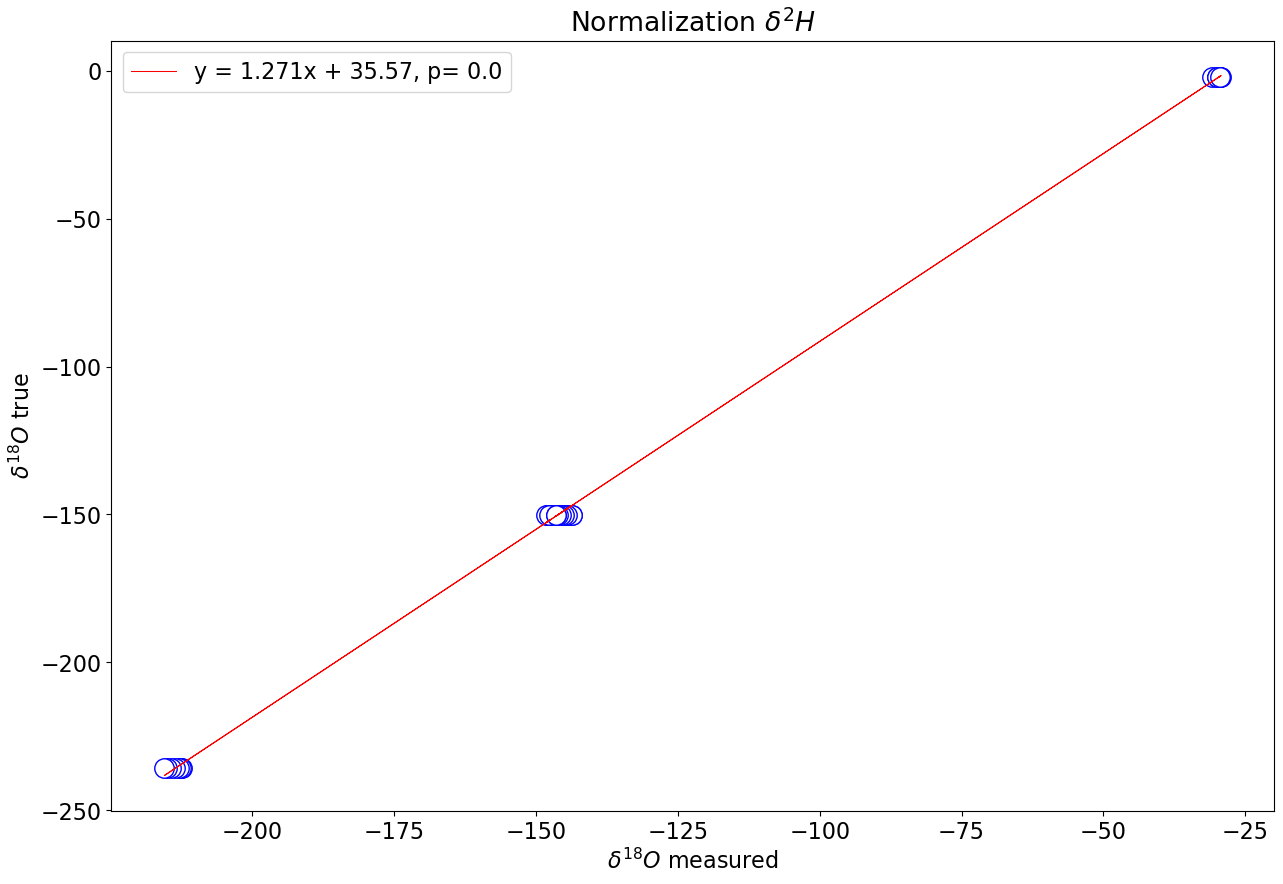

In [56]:
slope, intercept, r_value, p_value, std_err = stats.linregress(norm['d(D_H)_driftcorrected'], norm['d(D_H)_true'])


norm['d(D_H)_normalized'] = norm.apply(lambda x: normalize(x['d(D_H)_driftcorrected'],slope,intercept), axis=1)

if plots_on == True:
    fig, ax = plt.subplots()
    x = norm['d(D_H)_driftcorrected']
    y = slope*x + intercept
    ax.plot(norm['d(D_H)_driftcorrected'],
            norm['d(D_H)_true'],
            'bo',mfc='white')

    ax.plot(x,y,'r-',
            label="y = " + str(round(slope,3)) + "x + " + str(round(intercept,2)) + ", p= " + str(round(p_value,3)))
    ax.set_xlabel('$\delta^{18}O$ measured')
    ax.set_ylabel('$\delta^{18}O$ true')
    ax.set_title('Normalization $\delta^{2}H$')
    ax.legend()

In [57]:
data['d(D_H)_normalized'] = data.apply(lambda x: normalize(x['d(D_H)_driftcorrected'],slope,intercept), axis=1)

## Check results (<font color=red>do not change</font>)

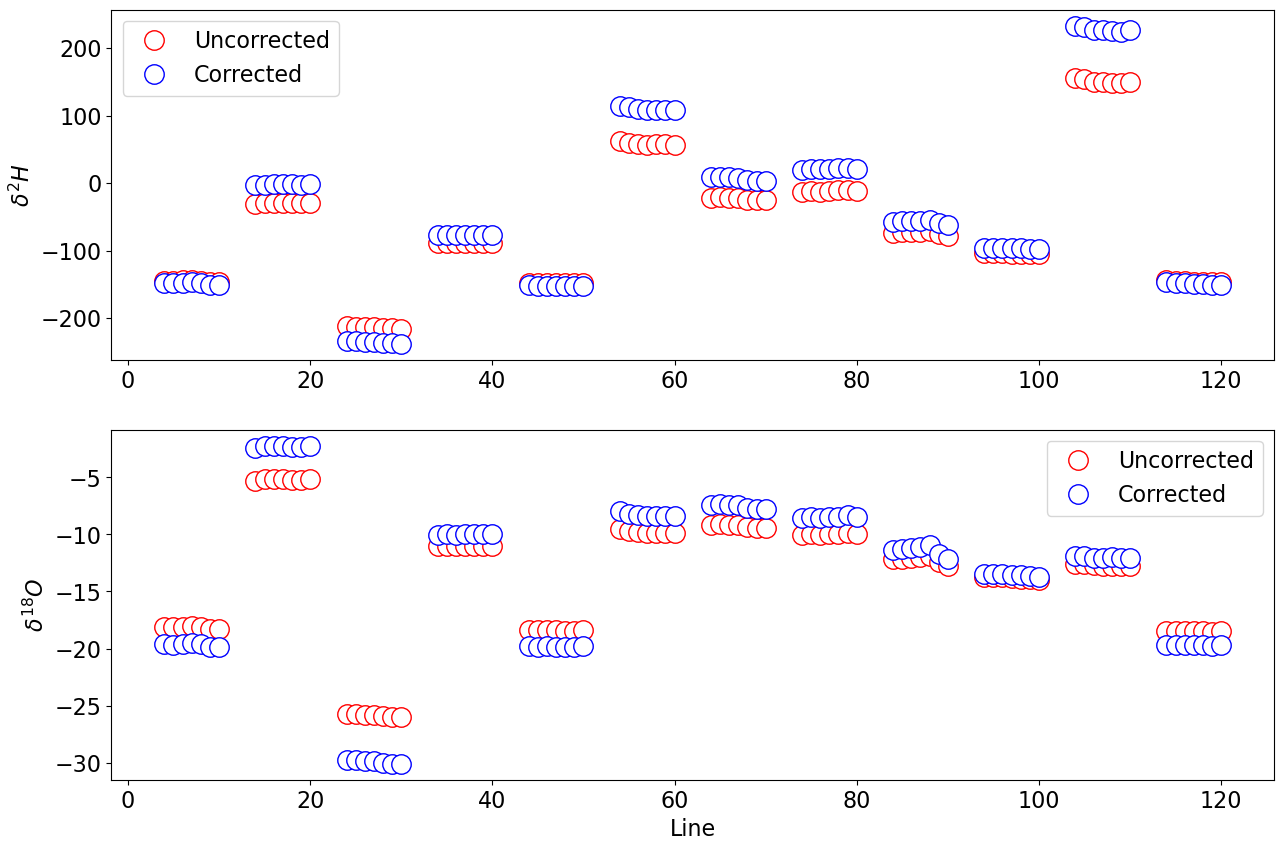

In [58]:
fig,(ax1,ax2) = plt.subplots(2,1)

ax1.plot(data['Line'],data['d(D_H)Mean'],'ro',mfc='white',label = 'Uncorrected')
ax1.plot(data['Line'],data['d(D_H)_normalized'],'bo',mfc='white',label = 'Corrected')
ax1.set_ylabel('$\delta^{2}H$')
ax1.legend()

ax2.plot(data['Line'],data['d(18_16)Mean'],'ro',mfc = 'white',label = 'Uncorrected')
ax2.plot(data['Line'],data['d(18_16)_normalized'],'bo',mfc='white',label = 'Corrected')
ax2.set_ylabel('$\delta^{18}O$')
ax2.set_xlabel('Line')
ax2.legend()

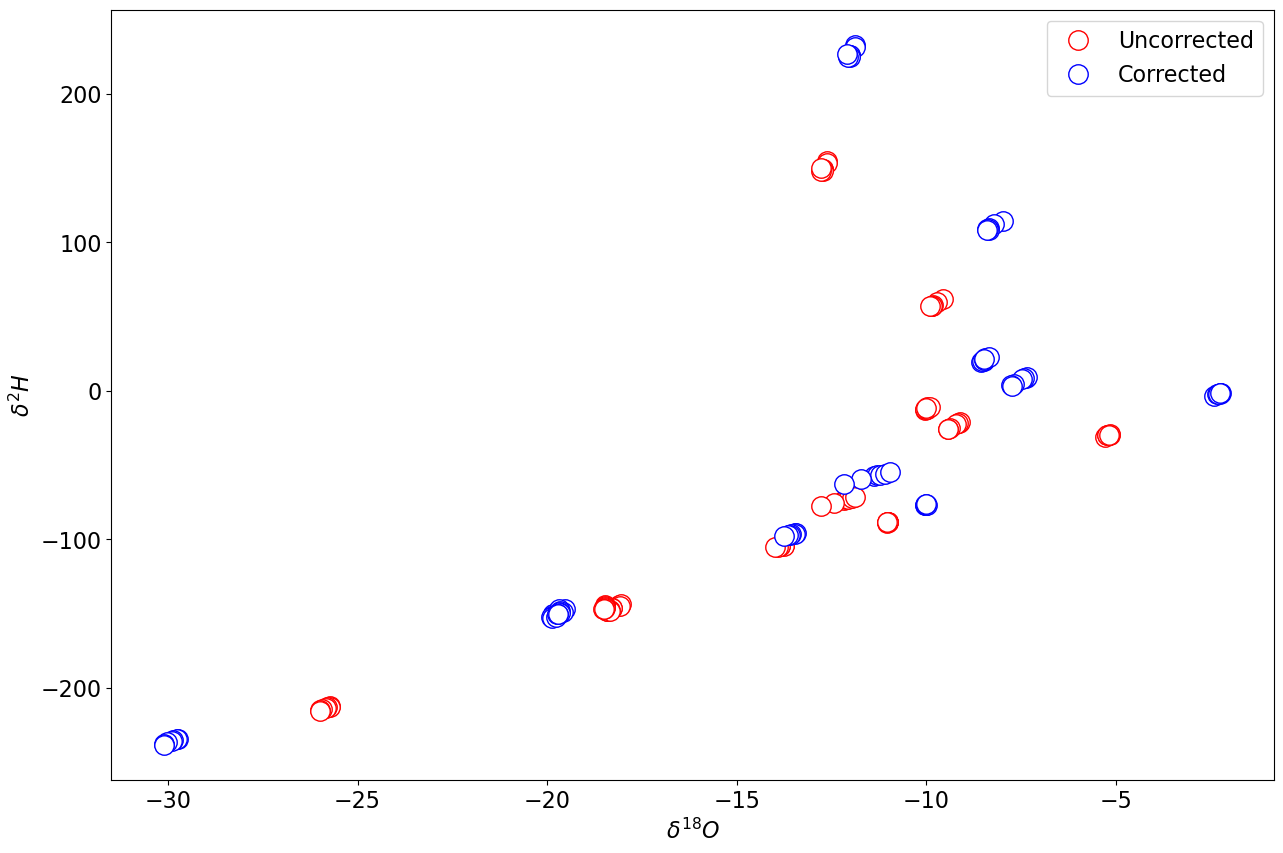

In [59]:
fig,ax = plt.subplots()
ax.plot(data['d(18_16)Mean'],data['d(D_H)Mean'],'ro',mfc = 'white',label = 'Uncorrected')
ax.plot(data['d(18_16)_normalized'],data['d(D_H)_normalized'],'bo',mfc = 'white',label = 'Corrected')
ax.set_xlabel('$\delta^{18}O$')
ax.set_ylabel('$\delta^{2}H$')
ax.legend()

## Choose number of injections to keep, output processed file (<font color=red>do not change</font>)

In [60]:
variables = ['d(18_16)Mean','d(D_H)Mean','H2O_Mean','Identifier1',
        'd(D_H)_driftcorrected','d(18_16)_driftcorrected','d(18_16)_normalized', 'd(D_H)_normalized']

In [61]:
# Choose number of injections to keep for each sample
keep = 4
    
indices = []
for name in data[~data['Identifier1'].str.contains('standard|USGS')]['Identifier1'].unique():
    temp = data[data['Identifier1']==name]
    indices.append(temp.index[-1*keep:])

indices = np.array(indices).ravel()

final = data.loc[indices,:][variables].groupby('Identifier1').agg('mean')
final['Identifier1'] = final.index
final = final.reset_index(drop=True)

In [62]:
# Initialize precision columns
final['d(18_16)_stddev'] = 0
final['d(D_H)_stddev'] = 0

In [63]:
stddev = data.loc[indices,:][variables].groupby('Identifier1').agg('std')
stddev['Identifier1'] = stddev.index
stddev = stddev.reset_index(drop=True)

stddevsH = []
for name in stddev['Identifier1'].unique():
    stddevsH.append(stddev[stddev['Identifier1']==name]['d(D_H)_normalized'] )

stddevsO = []
for name in stddev['Identifier1'].unique():
    stddevsO.append(stddev[stddev['Identifier1']==name]['d(18_16)_normalized'] )
    
final['d(D_H)_stddev'] = np.array(stddevsH)
final['d(18_16)_stddev'] = np.array(stddevsO)

In [64]:
final.to_csv('./Picarro_processed_data/' + file_name.replace('HIDS2533_IsoWater_','') + '_processed.csv')